# Logistic regression with an evolutionary algorithm

In this notebook, we will show how to use Auxein and a simple evolutionary algorithm to perfom a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).

In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

logging.getLogger().setLevel(logging.CRITICAL)

As a first step, we will generate a sigmoid function and we sample (and round to the closest integer) $100$ data points from it (in the form of $(x_{i},y_{i})$) which will represent our observations of a binary classification $y = f(x)$ where $y_{i} \in \{0, 1\}$

In [2]:
x = np.sort(np.random.choice(np.arange(-50, 50, 0.01), 100))

alpha = -1.5
b0 = 0.125 
y = 1 / (1 + np.exp(-(alpha + b0*x)))
y_rounded = np.array(list(map(lambda yi: round(yi), y)))

And then we visualise our observations $(x_{i},y_{i})$:

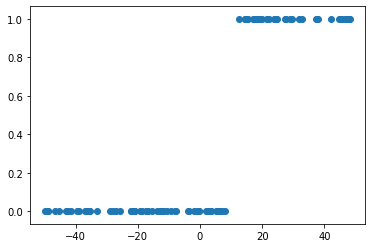

In [3]:
plt.scatter(x, y_rounded);

From now on, we will only assume that we have our observations $(x_{i},y_{i})$ and we will pretend that we do not know the function $y = f(x)$ that generated them.

Our goal is to find a function $\hat{f}$ such as $\hat{f} \sim f$, which means finding a function that can approximate the underlying (unknown) function that generates our observations.

The first thing to do is to use the $(x,y)$ observations and wrap them with a [Fitness function](https://github.com/auxein/auxein/blob/master/auxein/fitness/core.py#L15) $\phi$ that Auxein can explore.

Auxein comes with some pre-defined fitness functions. In this case, given that our problem can be modeled as a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), we will use the [MaximumLikelihood](https://github.com/auxein/auxein/blob/master/auxein/fitness/observation_based.py#L73).

In [6]:
from auxein.fitness.observation_based import MaximumLikelihood
fitness_function = MaximumLikelihood(x.reshape(100, 1), y_rounded)

Then, the second step is to create an initial `population` of individuals. Each `individual` maps to candidate solution, which in this case would be a vector $(\alpha, \beta_{0})$ that fully specify a logistic regression model.

Auxein provides some utility functions to create initial populations, like the `build_fixed_dimension_population` used below.

In [7]:
from auxein.population.dna_builders import UniformRandomDnaBuilder
from auxein.population import build_fixed_dimension_population
population = build_fixed_dimension_population(2, 100, fitness_function, UniformRandomDnaBuilder((-0.01, 0.01)))

Once we have a `fitness_function` and an initial `population`, we need to set up a [Playground](https://github.com/auxein/auxein/blob/master/auxein/playgrounds/static.py#L27).
A playground is basically the object that represents our experiment.

In [8]:
from auxein.playgrounds import Static
from auxein.mutations import SelfAdaptiveSingleStep
from auxein.recombinations import SimpleArithmetic
from auxein.parents.distributions import SigmaScaling
from auxein.parents.selections import StochasticUniversalSampling
from auxein.replacements import ReplaceWorst

In order to instantiate a `playground` the following must be specified:
* `mutation` strategy, which describes how `individual` dna will mutate. In this case we will use the [SelfAdaptiveSingleStep](https://github.com/auxein/auxein/blob/master/auxein/mutations/core.py#L62).
* parents `distribution`, which gives a probability distribution for parents `selection`. We here use [SigmaScaling](https://github.com/auxein/auxein/blob/master/auxein/parents/distributions/core.py#L43) for distribution and [StochasticUniversalSampling](https://github.com/auxein/auxein/blob/master/auxein/parents/selections/core.py#L27) for selection.
* `recombination` defines how fresh dna are created when `individual`s breed. Here we use the basic [SimpleArithmetic](https://github.com/auxein/auxein/blob/master/auxein/recombinations/core.py#L23).
* for `replacement` we will use the basic [ReplaceWorst](https://github.com/auxein/auxein/blob/master/auxein/replacements/core.py#L34) which basically only replaces the 2-worst performing individuals.

In [9]:
offspring_size = 4
playground = Static(
    population = population,
    fitness = fitness_function,
    mutation = SelfAdaptiveSingleStep(0.05),
    distribution = SigmaScaling(),
    selection = StochasticUniversalSampling(offspring_size = offspring_size),
    recombination = SimpleArithmetic(alpha = 0.5),
    replacement = ReplaceWorst(offspring_size = offspring_size)
)

Invoking `playground.train(max_generations=200)` will trigger the evolution process up to a maximum of $2o0$ generations.

In [ ]:
stats = playground.train(200)

Once the training phase has ended, the `playground` returns a dictionary with some basic statistics on the population.

In [11]:
population.get_stats()

{'generation_count': 200,
 'size': 100,
 'mean_age': 11.382943091392518,
 'std_age': 2.7466001141174465,
 'max_age': 19.073707103729248,
 'min_age': 7.5454676151275635,
 'mean_fitness': 95.94936639758845,
 'min_fitness': 89.88305025536772,
 'max_fitness': 98.5427431177904,
 'std_fitness': 1.5003278526771748}

To get the most performant `individual` we can invoke `playground.get_most_performant()` and grab the dna of the individual.

In [12]:
[alpha_star, *coeff] = playground.get_most_performant().genotype.dna

In [13]:
[alpha_star, *coeff]

[-6.100514545336547, 0.689517381351941]

Once we have $\alpha$ and $\beta_{0}$, it might be useful to plot $\hat{f(x)} = \frac{1}{1 - e^-{(\alpha + \beta_{0}x)}}$ against our observations $(x_{i},y_{i})$, to visually inspect the quality of our regression:

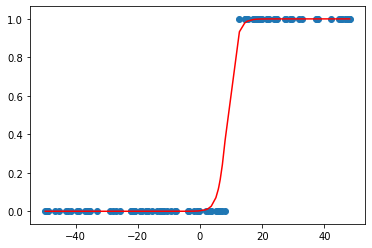

In [15]:
y_pred = 1 / (1 + np.exp(-(alpha_star + coeff*x)))
plt.scatter(x, y_rounded);
plt.plot(x, y_pred, color='red');